<a href="https://colab.research.google.com/github/Jathurshan0330/Cine-Cardiac-MRI-Motion-Artefact-Reduction/blob/master/Cine_Cardiac_MRI_Motion_Artifact_Reduction_Using_a_Recurrent_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Get Requirements

In [4]:
!git clone https://github.com/Jathurshan0330/Cine-Cardiac-MRI-Motion-Artefact-Reduction.git

Cloning into 'Cine-Cardiac-MRI-Motion-Artefact-Reduction'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 7 (delta 0), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from IPython.display import clear_output

In [7]:
!pip install medpy
clear_output()

In [97]:
%cd /content/Cine-Cardiac-MRI-Motion-Artefact-Reduction
import torch
import os
from glob import glob
import time
import re
import argparse
import nibabel as nib
import pandas as pd
from medpy.metric.binary import hd, dc
import numpy as np
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch
import torch.nn as nn
sns.set_style('darkgrid')
from seaborn.matrix import clustermap



from utils.metrics_acdc import load_nii

/content/Cine-Cardiac-MRI-Motion-Artefact-Reduction


#Load and Visualize Data

In [103]:
img_data_4d, affine_4d, header_4d = load_nii("/content/drive/MyDrive/Cine Cardiac/training/patient021/patient021_4d.nii.gz")
# img_data_4d = np.moveaxis(img_data_4d,0,1)
print(img_data_4d.shape, affine_4d.shape)

# print(header_4d)

# img_data_f1, affine_f1, header_f1 = load_nii("/content/drive/MyDrive/Cine Cardiac/training/patient001/patient001_frame01.nii.gz")
# print(img_data_f1.shape, affine_f1.shape)
# # print(header_f1)

# img_data_g1, affine_g1, header_g1 = load_nii("/content/drive/MyDrive/Cine Cardiac/training/patient001/patient001_frame01_gt.nii.gz")
# print(img_data_g1.shape, affine_g1.shape)
# # print(header_g1)

# img_data_f12, affine_f12, header_f12 = load_nii("/content/drive/MyDrive/Cine Cardiac/training/patient001/patient001_frame12.nii.gz")
# print(img_data_f12.shape, affine_f12.shape)
# # print(header_f12)

# img_data_g12, affine_g12, header_g12 = load_nii("/content/drive/MyDrive/Cine Cardiac/training/patient001/patient001_frame12_gt.nii.gz")
# print(img_data_g12.shape, affine_g12.shape)
# # print(header_g12)

(240, 256, 10, 30) (4, 4)


In [104]:
# def interactive_plot(frame,Gt, cmap = 'jet'):
#   def plot_image(slice):
#     print(f"Plotting {slice} Slice")
#     fig, ax = plt.subplots(1,2, figsize=(10,10))
#     ax[0].imshow(frame[:,:,slice], cmap='gray', interpolation ='bilinear'), ax[0].set_title('Frame',fontsize = 10),ax[0].axis("off")
#     ax[1].imshow(Gt[:,:,slice], cmap='gray'), ax[1].set_title('Gt',fontsize = 10),ax[1].axis("off")
#     plt.show()

#   select_slice = IntSlider(min=0, max=frame.shape[2]-1, description='Select Slice', continuous_update=True)

#   # select_phase = IntSlider(min=0, max=frame.shape[3]-1, description='Select Phase', continuous_update=True)

#   return interactive(plot_image, slice=select_slice)#, phase = select_phase)

# interactive_plot(img_data_f1,img_data_g1, cmap = 'gray')

In [105]:
from matplotlib.animation import FuncAnimation
from IPython import display

In [118]:
def interactive_gif(img, cmap = 'jet'):
  
  def Animate(slice):
    Figure = plt.figure() 
    # creating a plot
    # imgs_plotted = plt.imshow(img[:,:,0,slice], cmap = 'gray') 
    imgs_plotted = plt.imshow(img[:,:,slice,0], cmap = 'gray') 
    plt.axis("off")

    def AnimationFunction(frame):
    
        # setting y according to frame
        # number and + x. It's logic
        # y = img[:,:,frame,slice]
        y = img[:,:,slice,frame]
    
        # line is set with new values of x and y
        imgs_plotted.set_data(y)

    # anim_created = FuncAnimation(Figure, AnimationFunction, frames=img.shape[2]-1, interval=200)
    anim_created = FuncAnimation(Figure, AnimationFunction, frames=img.shape[-1]-1, interval=100)

    video = anim_created.to_html5_video()
    html = display.HTML(video)
    display.display(html)
  
  # good practice to close the plt object.
    plt.close()

  # select_slice = IntSlider(min=0, max=img.shape[-1]-1, description='Select Phase', continuous_update=True)
  select_slice = IntSlider(min=0, max=img.shape[2]-1, description='Select slice', continuous_update=True)

  # select_phase = IntSlider(min=0, max=frame.shape[3]-1, description='Select Phase', continuous_update=True)

  return interactive(Animate, slice=select_slice)#, phase = select_phase)
interactive_gif(img_data_4d, cmap = 'gray')

interactive(children=(IntSlider(value=0, description='Select slice', max=7), Output()), _dom_classes=('widget-…

## Data Analysis

In [121]:
data_list = glob("/content/drive/MyDrive/Cine Cardiac/training/patient*/patient*_4d.nii.gz")
print(data_list)
phase_list = []
slice_list = []
ignore = ["/content/drive/MyDrive/Cine Cardiac/training/patient009/patient009_4d.nii.gz",]

for i in data_list:
  if i in ignore:
    phase_list.append(0)
    slice_list.append(0)
    continue
  img_data_4d, affine_4d, header_4d = load_nii(i)
  phase_list.append(img_data_4d.shape[-1])
  slice_list.append(img_data_4d.shape[-2])


print(phase_list)
print(slice_list)


['/content/drive/MyDrive/Cine Cardiac/training/patient001/patient001_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient002/patient002_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient003/patient003_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient004/patient004_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient005/patient005_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient006/patient006_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient007/patient007_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient008/patient008_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient009/patient009_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient010/patient010_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient011/patient011_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient012/patient012_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/tr

In [127]:
#select scans with 30 phase
select_list = []
for i in range (len(phase_list)):
  if phase_list[i] == 30:
    select_list.append(data_list[i])
print(select_list)
print(len(select_list))

['/content/drive/MyDrive/Cine Cardiac/training/patient001/patient001_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient002/patient002_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient003/patient003_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient005/patient005_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient012/patient012_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient013/patient013_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient014/patient014_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient016/patient016_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient019/patient019_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient021/patient021_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient027/patient027_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient029/patient029_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/tr

In [130]:
## Separate into train and val
train_list = select_list[:-7]
val_list = select_list[-7:]
print(len(train_list), len(val_list))

37 7


/content/drive/MyDrive/Cine Cardiac/training/patient044/patient044_4d.nii.gz
(256, 216, 9, 30)
(100, 100, 30) 0 1928


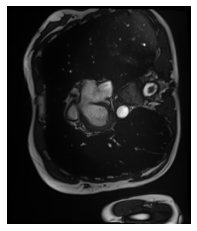

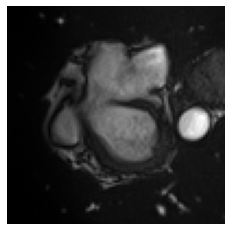

(100, 100, 30) 7 2256


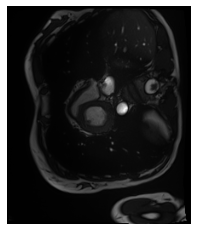

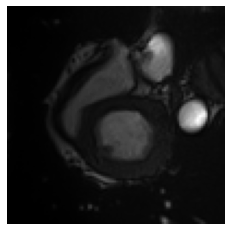

(100, 100, 30) 7 894


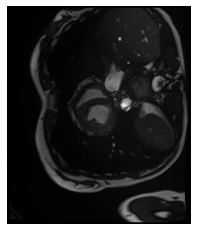

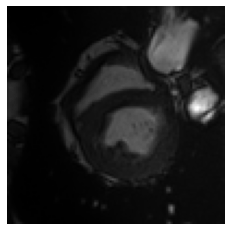

(100, 100, 30) 5 650


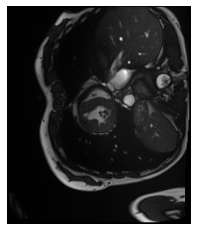

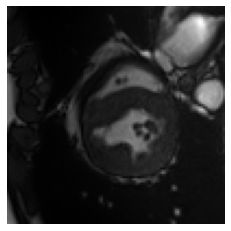

(100, 100, 30) 6 746


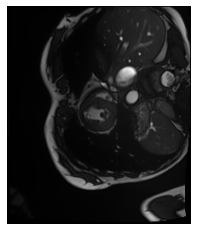

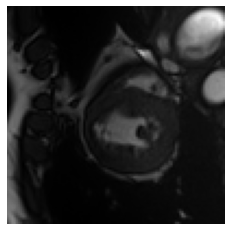

(100, 100, 30) 2 566


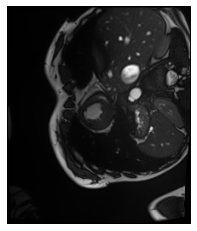

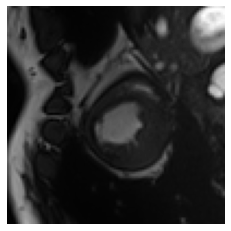

(100, 100, 30) 0 486


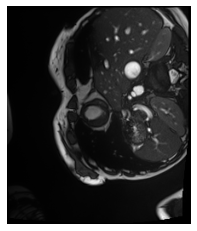

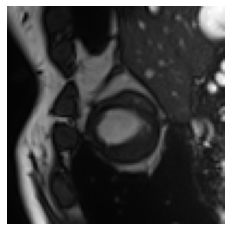

(100, 100, 30) 0 456


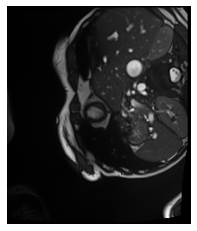

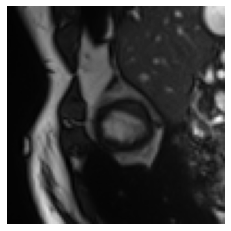

(100, 100, 30) 0 472


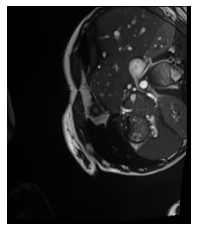

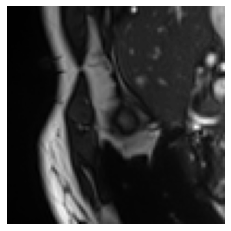

In [217]:
#Create Train Data
import h5py

img_no = 17
index = [120,100]  #11 [80,140]    #10 [80,120]   #7 [90,130]   #3,6,17 [120,100]     #0-2, 4-5, 8- 10, 12-16, [100,130] 
print(train_list[img_no])
img_data_4d, affine_4d, header_4d = load_nii(train_list[img_no])
print(img_data_4d.shape)
save_path = "/content/drive/MyDrive/Cine Cardiac/train_data/"

for slice_no in range(img_data_4d.shape[-2]): 
  img_frames = img_data_4d[index[0]-50:index[0]+50,index[1]-50:index[1]+50,slice_no,:]
  print(img_frames.shape,img_frames.min(),img_frames.max())


  plt.figure()
  plt.imshow(img_data_4d[:,:,slice_no,14],cmap='gray')
  plt.axis('off')
  plt.show()

  plt.figure()
  plt.imshow(img_frames[:,:,14],cmap='gray')
  plt.axis('off')
  plt.show()

  hf = h5py.File(save_path+f'train_{train_list[img_no][-13:-10]}_slice_{slice_no}.h5', 'w')
  hf.create_dataset('train', data = img_frames)
  hf.close()


In [218]:
h5_file = "/content/drive/MyDrive/Cine Cardiac/train_data/train_044_slice_1.h5"

with h5py.File(h5_file, "r") as f:
  print("Keys: %s" % f.keys())
  a_group_key = list(f.keys())[0]

  # Get the data
  img_test = np.array((f[a_group_key]))
  print(len(img_test))
img_test = np.reshape(img_test,(100,100,1,30))
interactive_gif(img_test, cmap = 'gray')

Keys: <KeysViewHDF5 ['train']>
100


interactive(children=(IntSlider(value=0, description='Select slice', max=0), Output()), _dom_classes=('widget-…

## Load Dataset Class

In [ ]:
from ast import Index
class CineCardiac(Dataset):
    def __init__(self, data_list, device,data_type = None,  transform=None, target_transform=None):
        
        first = True
        for base in data_list:
          if first:
            self.img_data, _, _ = load_nii(base)
            first = False
          else:
            self.img_data = np.concatenate((self.img_data,load_nii(base)[0]),axis = 0)

        print(self.img_data.shape)    
        self.device = device
        self.transform = transform
        self.target_transform = target_transform


    def __len__(self):
        return len(self.flair)

    def __getitem__(self, idx):
      img = self.img_data[Index]
      
      if self.transform:
          img = self.transform(img).to(self.device)     
      return img, label